In [1]:
import copy
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from tqdm.auto import tqdm

import multitask.dataset as dataset
import multitask.models.task_switching.hooks as hooks
from multitask.models.task_switching.models import get_task_model
from multitask.representations import get_mean_activations, calculate_rdm, plot_rdm
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs

In [2]:
plt.style.use('../style/plots.mplstyle')

seaborn_props = {
    'boxprops': {'edgecolor':'black', 'linewidth': 1},
    'medianprops': {'color':'black', 'linewidth': 1},
    'whiskerprops': {'color':'black', 'linewidth': 1},
    'capprops': {'color':'black', 'linewidth': 1}
}

In [3]:
path_data = os.path.join('..', '..', 'data')
path_model_task_switching = os.path.join('..', '..', 'results', 'task_switching')
path_pickle = os.path.join('pickle', 'rdm_task_switching.pickle')

In [4]:
path_figure_rdm = os.path.join('svg', 'figureS25_rdm_task_switching.svg')
path_figure_noise = os.path.join('svg', 'figureS25_digits_noise.svg')
path_figure_snr = os.path.join('svg', 'figureS25_snr_task_switching.svg')
path_figure_rsa = os.path.join('svg', 'figureS25_rsa_task_switching.svg')

In [5]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 50
num_hidden = 5 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value']
idxs_contexts = list(range(len(num_hidden)))

In [6]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': idxs_contexts
}

data_folder = check_runs(path_model_task_switching, parameters)

Found simulation in ../../results/task_switching with the same parameters (2022-09-28_00_18_47)


In [7]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [8]:
seeds = sorted(list(results_task_switching.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value']


In [9]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = 1

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

parity: [1, 0]
value: [0, 1]


In [10]:
def calculate_snr(images, noise):
    mean_power_images = torch.mean(images ** 2, dim=1)
    mean_power_noise = torch.mean(noise ** 2, dim=1)
    snr = 10 * torch.log10(mean_power_images / mean_power_noise)
    return torch.mean(snr)

In [11]:
device = get_device()
criterion = nn.CrossEntropyLoss()
num_layers = len(num_hidden)
list_rdm = []
data_size = task_switching_tasks['parity']['data'].data.shape

array_noise = [0.0, 0.25, 0.5, 0.75, 1.0]
num_noise = len(array_noise)

dict_rdm = {}
snr = np.zeros((num_runs, num_noise))
images = []

for i_seed, seed in tqdm(enumerate(seeds), total=num_runs):
    torch.manual_seed(seed)
    dict_rdm[seed] = {}

    for i_noise, noise in enumerate(array_noise):
        state_dict = results_task_switching[seed]['model']
        model = get_task_model(task_switching_tasks,
                            num_hidden,
                            idxs_contexts,
                            device)
        model.load_state_dict(state_dict)
        
        indices = results_task_switching[seed]['indices']

        test_sampler = dataset.SequentialSampler(indices['test'])

        noise_data = noise * torch.randn(size=data_size)
        noise_task_switching_tasks = copy.deepcopy(task_switching_tasks)
        noise_task_switching_tasks['parity']['data'].data += noise_data
        noise_task_switching_tasks['value']['data'].data += noise_data

        if i_seed == 0:
            images.append((noise, noise_task_switching_tasks['parity']['data'].data[1].numpy().reshape(28, 28)))

        indices_test = indices['test']
        test_images = task_switching_tasks['parity']['data'].data[indices_test]
        noise_images = noise_data[indices_test]
        
        snr[i_seed, i_noise] = calculate_snr(test_images, noise_images)

        _, test_dataloaders = dataset.create_dict_dataloaders(noise_task_switching_tasks,
                                                            indices,
                                                            batch_size=batch_size)
        tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

        numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
        numbers = numbers[indices['test']]

        _, activations = hooks.get_layer_activations(model,
                                                    tasks_testloader,
                                                    criterion,
                                                    device=device,
                                                    disable=True)

        mean_activations = get_mean_activations(activations,
                                        num_hidden,
                                        list_labels=numbers,
                                        tasks_names=tasks_names)

        rdm_dict = calculate_rdm(mean_activations,
                                tasks_names=tasks_names)

        dict_rdm[seed][noise] = rdm_dict

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
mean_rdm = {}
size_rdm = dict_rdm[seeds[0]][array_noise[0]][1].shape

for i_noise, noise in tqdm(enumerate(array_noise), total=num_noise):
    mean_rdm[noise] = {}
    for layer in range(1, num_layers+1):
        rdm = np.zeros(size_rdm)
        for i_seed, seed in enumerate(seeds):
            rdm += dict_rdm[seed][noise][layer]
        mean_rdm[noise][layer] = rdm / num_runs

  0%|          | 0/5 [00:00<?, ?it/s]

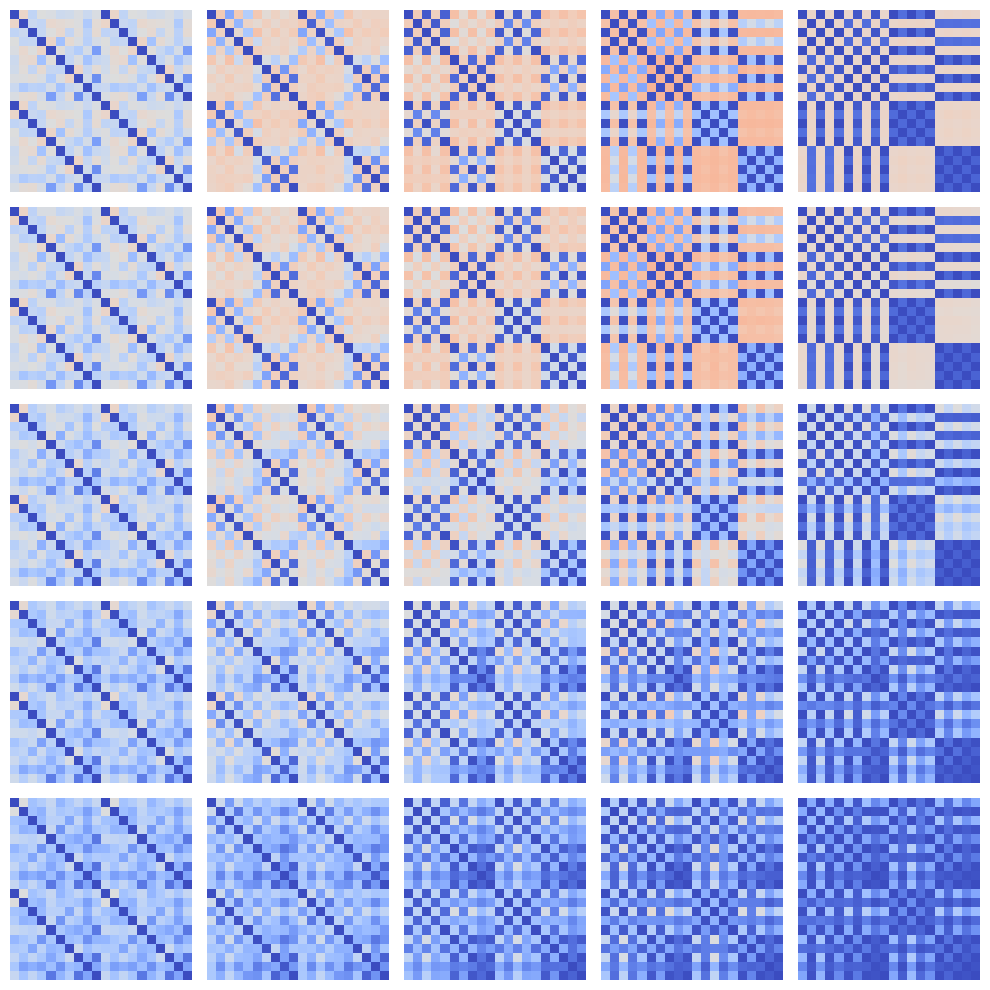

In [13]:
fig, ax = plt.subplots(num_noise, num_layers, figsize=(2 * num_layers, 2 * num_noise))

for i_noise, noise in enumerate(array_noise):
    plot_rdm(ax[i_noise], mean_rdm[noise], num_hidden, cmap='coolwarm', vmin=0, vmax=2)

fig.tight_layout()
fig.savefig(path_figure_rdm)
plt.show()

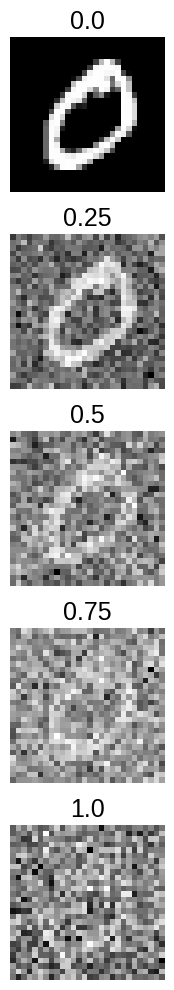

In [14]:
fig, ax = plt.subplots(num_noise, 1, figsize=(10, 10))

for i, (noise, image) in enumerate(images):
    ax[i].imshow(image, cmap='Greys_r')
    ax[i].set_title(noise)
    ax[i].axis('off')

fig.tight_layout()
fig.savefig(path_figure_noise)
plt.show()

In [15]:
df_snr = pd.DataFrame({}, columns=['SNR', 'Noise'])

for i_noise in range(1, num_noise):
    df_iter = pd.DataFrame({'SNR': snr[:, i_noise], 'Noise': f'{array_noise[i_noise]}'})
    df_snr = pd.concat((df_snr, df_iter))

df_snr.reset_index(drop=True, inplace=True)

In [16]:
mean_df = df_snr.groupby('Noise')['SNR'].mean().reset_index()

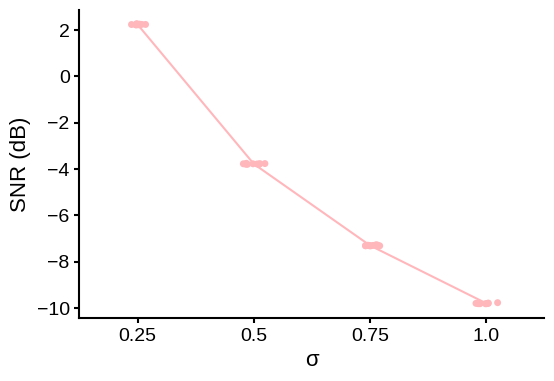

In [17]:
fig = plt.figure(figsize=(6, 4))

sns.lineplot(x='Noise', y='SNR', data=mean_df, color="#FFB7BC")
sns.stripplot(x='Noise', y='SNR', data=df_snr, color="#FFB7BC")

plt.xlabel('σ')
plt.ylabel('SNR (dB)')

fig.savefig(path_figure_snr)

plt.show()

In [18]:
layer = 5
rsa_noise = np.zeros((num_runs, num_noise))

for i_noise, noise in enumerate(array_noise): 
    for i_seed, seed in enumerate(seeds):
        noiseless_rdm = dict_rdm[seed][0][layer]
        noise_rdm = dict_rdm[seed][noise][layer]
        rsa_noise[i_seed, i_noise] = np.corrcoef(noiseless_rdm.flatten(), noise_rdm.flatten())[0, 1]


In [19]:
df_rsa = pd.DataFrame({}, columns=['RSA', 'Noise'])

for i_noise in range(1, num_noise):
    df_iter = pd.DataFrame({'RSA': rsa_noise[:, i_noise], 'Noise': array_noise[i_noise]})
    df_rsa = pd.concat((df_rsa, df_iter))

df_rsa.reset_index(drop=True, inplace=True)

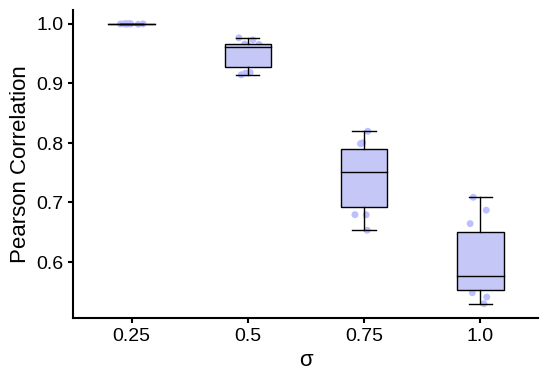

In [20]:
fig = plt.figure(figsize=(6, 4))

sns.boxplot(x='Noise', y='RSA', data=df_rsa, color="#BDC0FF", showfliers=False, width=0.4, **seaborn_props)
sns.stripplot(x='Noise', y='RSA', data=df_rsa, color="#BDC0FF", dodge=True, zorder=-1)

plt.xlabel('σ')
plt.ylabel('Pearson Correlation')
plt.tick_params(labelsize=14)

fig.savefig(path_figure_rsa)

plt.show()